# Installing Libraries and Downloading CSV

In [10]:
# %pip install --upgrade pandas
# %pip install --upgrade nltk
# %pip install --upgrade contractions

In [11]:
import pandas as pd
from collections import Counter
import itertools 
import re
import contractions

import nltk
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('brown')
nltk.download('treebank')
nltk.download('stopwords')

ModuleNotFoundError: No module named 'contractions'

In [12]:
df_a = pd.read_csv("fake_job_postings_A.csv")
df_b = pd.read_csv("fake_job_postings_B.csv")

df = pd.concat([df_a, df_b], ignore_index=True)

df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


# Cleaning Dataframe

In [13]:
# It appears the tokenizing was already done for us, although the format is not very good for analysis
def textwash(col):
    df[col] = df[col].str.replace(r"http\w+", " url_token", regex=True) # urls
    df[col] = df[col].str.replace(r"https?://\w+", " url_token", regex=True) # urls
    df[col] = df[col].str.replace(r"#URL_\w+", " url_token", regex=True) # urls

    df[col] = df[col].str.replace(r"#EMAIL_\w+", " email_token", regex=True) # email

    df[col] = df[col].str.replace(r"$\d+", " money_token", regex=True) # money

    df[col] = df[col].str.replace("\xa0", " ") # Non-breaking space
    df[col] = df[col].str.replace("&amp", " ") # Ampersand

    df[col] = df[col].str.replace(r"[^\w\s]", " ", regex=True) # remove nonword characters generally
    df[col] = df[col].str.replace(r"\s{2,}", " ", regex=True) # reduce repeat spaces
    df[col] = df[col].str.lower()

In [14]:
# Tokenize urls, emails, and money, remove nonword characters
df = df[df['company_profile'].str.len() > 0]
df = df[df['description'].str.len() > 0]
df = df[df['requirements'].str.len() > 0]
df = df[df['benefits'].str.len() > 0]

textwash("company_profile")
textwash("description")
textwash("requirements")
textwash("benefits")

df["description"].head()

1    organised focused vibrant awesome do you have ...
3    the company esri environmental systems researc...
4    job title itemization review managerlocation f...
6    your responsibilities manage the english speak...
7    who is airenvy hey there we are seasoned entre...
Name: description, dtype: object

# EDA, Non-text Data Analysis, Topic Analysis

In [15]:
# Summary Statistics
import numpy as np
from scipy import stats

fraud_lens = [len(desc) for desc in df[df["fraudulent"] == 1]["description"] if not isinstance(desc, float)]
legit_lens = [len(desc) for desc in df[df["fraudulent"] == 0]["description"] if not isinstance(desc, float)]

x = stats.ttest_ind(fraud_lens, legit_lens, alternative='less')

print(f"Mean length of fraudulent description: {np.mean(fraud_lens)}\n\
      Mean length of legitimate description: {np.mean(legit_lens)}\n\
      P-value of one-sided t-test: {x.pvalue}")

ModuleNotFoundError: No module named 'scipy'

In [ ]:
# Set parameters for stop words and min word length, to be used later

global_stopwords = nltk.corpus.stopwords.words("english")
THRESHOLD = 3

In [ ]:
# Get list of words in the fraudulent descriptions

fraudulent_description = df[df["fraudulent"] == 1]["description"]

fraud_words = [nltk.word_tokenize(s) for s in fraudulent_description if isinstance(s, str)]
fraud_words = list(itertools.chain.from_iterable(fraud_words))
fraud_words = [w for w in fraud_words if len(w)> THRESHOLD and w not in global_stopwords]

fraud_words[0:5]

['technician', 'bakersfield', 'posoprincipal', 'duties', 'responsibilities']

In [ ]:
# Get most common words in fraudulent descriptions

fraud_counts = Counter(fraud_words)
fraud_counts.most_common(20)
fraud_freq = pd.DataFrame(fraud_counts.most_common(), columns=["Fraud_Term", "Frequency"])

fraud_freq.head(10)

,Fraud_Term,Frequency
0,work,261
1,team,207
2,product,171
3,engineering,169
4,products,156
5,project,154
6,customer,141
7,position,141
8,equipment,137
9,provide,136


In [ ]:
# Get list of words in the legitimate descriptions

legitimate_description = df[df["fraudulent"] == 0]["description"]

legit_words = [nltk.word_tokenize(s) for s in legitimate_description if isinstance(s, str)]
legit_words = list(itertools.chain.from_iterable(legit_words))
legit_words = [w for w in legit_words if len(w) > THRESHOLD and w not in global_stopwords]

legit_words[0:5]

['organised', 'focused', 'vibrant', 'awesome', 'passion']

In [ ]:
# Get most common words in legitimate descriptions

legit_counts = Counter(legit_words)
legit_counts.most_common(20)
legit_freq = pd.DataFrame(legit_counts.most_common(), columns=["Legit_Term", "Frequency"])
legit_freq.head(10)

,Legit_Term,Frequency
0,team,9308
1,work,6871
2,sales,5621
3,company,5595
4,business,5426
5,looking,4715
6,customer,4218
7,marketing,4059
8,product,3962
9,development,3883


# Sentiment Analysis

In [ ]:
%pip install textblob nltk
%pip install nltk #ensuring nltk installation

333.06s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


338.78s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import nltk
nltk.download('vader_lexicon')  # VADER lexicon download/reinstall

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/elminaheder/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
%pip install pandas

import pandas as pd

df_a = pd.read_csv("fake_job_postings_A.csv")
df_b = pd.read_csv("fake_job_postings_B.csv")
df_combined = pd.concat([df_a, df_b], ignore_index=True)  # New variable name to avoid overwriting 'df'

572.49s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 11.3 MB 7.7 MB/s eta 0:00:01
     |████████████████████████████████| 5.3 MB 18.3 MB/s eta 0:00:01
     |████████████████████████████████| 347 kB 11.6 MB/s eta 0:00:01
     |████████████████████████████████| 509 kB 16.0 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [16]:
# Sentiment Analysis 
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

# Download required resources
nltk.download('vader_lexicon')

# TextBlob sentiment polarity (range: -1 to 1)
def textblob_sentiment(text):
    return TextBlob(str(text)).sentiment.polarity

df['textblob_sentiment'] = df['description'].apply(textblob_sentiment)

# VADER compound score (range: -1 to 1)
sid = SentimentIntensityAnalyzer()

def vader_sentiment(text):
    return sid.polarity_scores(str(text))['compound']

df['vader_sentiment'] = df['description'].apply(vader_sentiment)

# Optional: Convert VADER score into labels
def label_sentiment(score):
    if score > 0.05:
        return 'Positive'
    elif score < -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['vader_label'] = df['vader_sentiment'].apply(label_sentiment)

# View results
df[['description', 'textblob_sentiment', 'vader_sentiment', 'vader_label']].head()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/elminaheder/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,description,textblob_sentiment,vader_sentiment,vader_label
1,organised focused vibrant awesome do you have ...,0.277178,0.9954,Positive
3,the company esri environmental systems researc...,0.221875,0.9968,Positive
4,job title itemization review managerlocation f...,0.126033,0.9559,Positive
6,your responsibilities manage the english speak...,0.415000,0.8360,Positive
7,who is airenvy hey there we are seasoned entre...,0.252449,0.9979,Positive


In [19]:
# Installing 'seaborn' for visualization
%pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 294 kB 4.4 MB/s eta 0:00:01
     |████████████████████████████████| 7.8 MB 8.4 MB/s eta 0:00:01
     |████████████████████████████████| 111 kB 5.9 MB/s eta 0:00:01
     |████████████████████████████████| 2.8 MB 8.8 MB/s eta 0:00:01
     |████████████████████████████████| 64 kB 7.6 MB/s  eta 0:00:01
     |████████████████████████████████| 3.0 MB 9.0 MB/s eta 0:00:01
     |████████████████████████████████| 249 kB 14.0 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


Matplotlib is building the font cache; this may take a moment.


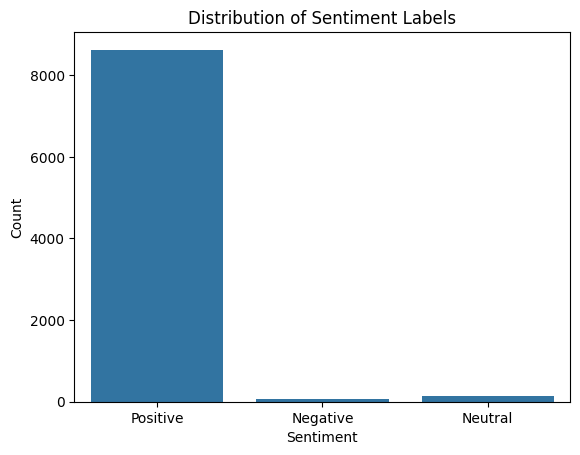

In [ ]:
# Visualization of Sentiment Analysis (Optional to Keep)...also lets us visualize and see next steps if needed for the project
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='vader_label', data=df)
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# Readibility Analysis

In [ ]:
# Installing packages
%pip install textstat

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 105 kB 3.6 MB/s eta 0:00:01
     |████████████████████████████████| 2.1 MB 4.4 MB/s eta 0:00:01
     |████████████████████████████████| 939 kB 13.9 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [21]:
import textstat

df['readability_fk'] = df['description'].apply(lambda x: textstat.flesch_kincaid_grade(str(x)))
df['readability_fre'] = df['description'].apply(lambda x: textstat.flesch_reading_ease(str(x)))
df['readability_gfi'] = df['description'].apply(lambda x: textstat.gunning_fog(str(x)))

In [22]:
# Results preview
df[['description', 'readability_fk', 'readability_fre', 'readability_gfi']].head()

,description,readability_fk,readability_fre,readability_gfi
1,organised focused vibrant awesome do you have ...,129.7,-262.81,133.38
3,the company esri environmental systems researc...,147.6,-331.16,151.80
4,job title itemization review managerlocation f...,81.4,-169.44,83.22
6,your responsibilities manage the english speak...,27.9,2.12,30.00
7,who is airenvy hey there we are seasoned entre...,162.4,-342.65,168.40


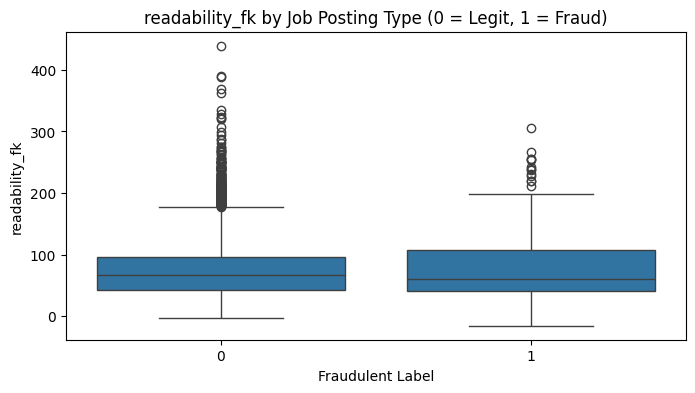

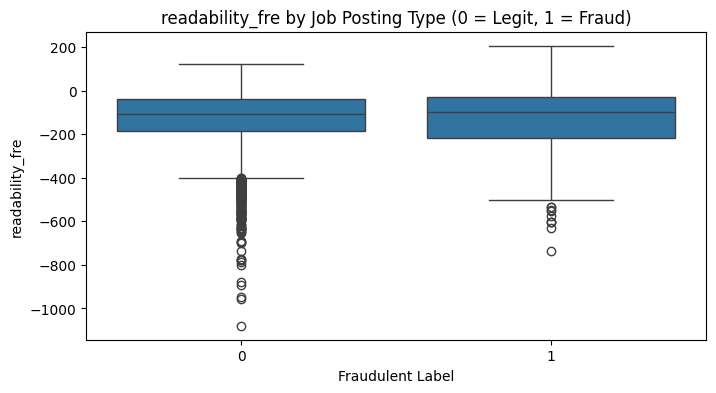

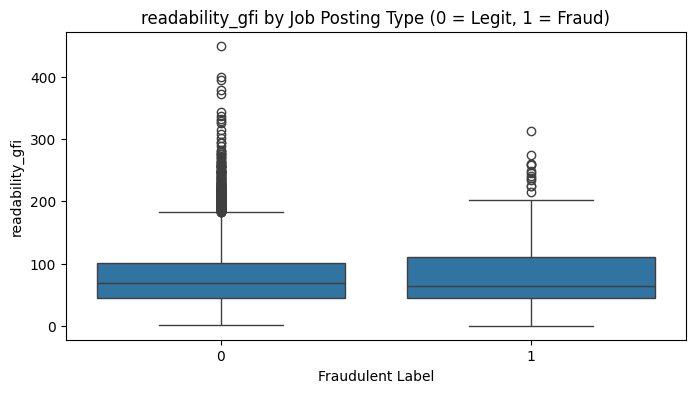

In [23]:
# Comparing readability scores between real vs faux job postings
import matplotlib.pyplot as plt
import seaborn as sns

# Boxplot
readability_metrics = ['readability_fk', 'readability_fre', 'readability_gfi']

for metric in readability_metrics:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='fraudulent', y=metric, data=df)
    plt.title(f'{metric} by Job Posting Type (0 = Legit, 1 = Fraud)')
    plt.xlabel('Fraudulent Label')
    plt.ylabel(metric)
    plt.show()

In [24]:
# Summary Statistics
df.groupby('fraudulent')[['readability_fk', 'readability_fre', 'readability_gfi']].mean()

,readability_fk,readability_fre,readability_gfi
fraudulent,,,
0,73.864428,-123.490692,76.979412
1,81.267464,-149.611148,84.434450


# Logistic Regression

In [ ]:
# %pip install --upgrade scikit-learn
# %pip install --upgrade scipy

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

In [ ]:
# Create vectorizer
vectorizer = CountVectorizer(stop_words=global_stopwords, ngram_range=(2,2))

In [ ]:
# Create train and test dfs
df_train, df_test = train_test_split(df, test_size=0.3, random_state=2021)
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)


# Create the training DTM and the labels
train_x = vectorizer.fit_transform([desc for desc in df_train['description'] if not isinstance(desc, float)])
train_y = df_train["fraudulent"]

test_x = vectorizer.transform([desc for desc in df_test['description'] if not isinstance(desc, float)])
test_y = df_test["fraudulent"]

# Check your answer
print(train_x.shape)
print(test_x.shape)

(6191, 270692)
(2654, 270692)


In [ ]:
# Run model
sparselr = LogisticRegression(penalty='l1',
                              solver='liblinear',
                              random_state=2021,
                              tol=0.001,
                              max_iter=1000,
                              C=100)
sparselr.fit(train_x, train_y)

print(sum(sparselr.coef_[0]!=0))

1789


In [ ]:
# Get model train and test accuracy
print("Train:")
print(roc_auc_score(train_y,sparselr.predict_proba(train_x)[:,1]))
print("Test:")
print(roc_auc_score(test_y,sparselr.predict_proba(test_x)[:,1]))

Train:
0.9999994754588162
Test:
0.9553042115809058


In [ ]:
# Words that most indicate a scam
dfbeta = pd.DataFrame({"Term": vectorizer.get_feature_names_out(),
                       "Beta": sparselr.coef_[0]})
dfbeta.sort_values(by="Beta", inplace=True, ascending=True)
dfbeta.reset_index(inplace=True, drop=True)
dfbeta.head(10)

,Term,Beta
0,fleet vehicles,-1.811061
1,join team,-1.294053
2,please apply,-1.258489
3,ideal candidate,-1.248609
4,social media,-1.206265
5,management team,-1.070550
6,rapidly growing,-1.050085
7,would like,-1.024795
8,new business,-1.014741
9,sales representative,-0.976549
